### Logistic Regression
The goal of this project is to practice creating a logistic regression model.  
For this practice project, I am going predict whether a titanic passenger survived or not, using the Titanic dataset: https://www.kaggle.com/datasets/vinicius150987/titanic3  
I will be creating a logistic regression model from scratch, so I will not be using libraties like Tensorflow or PyTorch.  
However, I'll be using pandas and numpy, because they make vector calculations quicker, matplotlib for visualization, and train_test_split from sklearn to split my data.  
I will be using the material that I learned from the Coursera course 'Machine Learning Specialization': https://www.coursera.org/specializations/machine-learning-introduction  
And from this Standford lecture video that I found on YouTube: https://www.youtube.com/watch?v=gqKaVgQxEJ0

In [10]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split

# Let's load the data into an initial pandas dataframa
df = pd.read_csv('titanic3.csv')

# And then take a look at the initial rows.
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


There aren't that many columns, so let's go by them one by one
- pclass - This is the kind of ticket the passenger bought. First class, second class or third class. Might be useful to predict survivorship. However, since a linear relationship is not guaranteed, I am going to one-hot encode these.
- survived - This is our y label. What we want to predict.
- name - Name of the passenger. I don't think this would influence whether someone survived. Drop it.
- sex - This is the sex of the passenger. Women and children where given priorite for the lifeboats, so this likely is important. One-hot encode it.
- age - Age of the passenger. Again, women and children first. Since it is simply a number, I'll use it as-is. But an idea could be to one-hot encode this as age groups, or as adult/child.
- sibsp - Number of siblings or spouses on board. Bigger families can warn or help each other, so could be important. Use as-is.
- parch - Number of parents / children on board. Same as above.
- ticket - Some kind of ticket ID? This might be able to tell where on the boat the passenger's cabin is, but I doubt there is a linear relationship between these numbers and survivorship, so I'll drop it.
- fare - This is the amount that the ticket cost. In a way, this also shows wealth, which could influence someone's chances to get off the boat. I'll use it as-is.
- cabin - The cabin where the passenger stayed in. This is not even filled in for most passengers. Drop it.
- embarked - This is what port the passenger embarked from. We can one-hot encode this.
- boat - This is what lifeboat a survivor used. Using this would be cheating, as only survivors have this filled in. Drop it.
- body - This is whether a body was found. Using this would be cheating, as only non-survivors have this filled in. Drop it.
- home.dest - This is the passenger's destination / home address. Not useful. Drop it.

In [11]:
# Let me create a number of lists for the columns

# A list of columns I want to one-hot encode
one_hot = ['pclass','sex','embarked']

# A list of columns I'll use as-is
as_is = ['age','sibsp','parch','fare']

# A list of columns I want to drop
drop_list = ['name','ticket','cabin','boat','body','home.dest']

# The y label
y_label = 'survived'

In [12]:
# Let's one=hot encode the values
for column in one_hot:
    one_hot_encoded = pd.get_dummies(df[column], prefix=column, dtype=int)
    df = pd.concat([df , one_hot_encoded], axis=1)
    df.drop(column, axis=1, inplace=True)

# Drop the values I want to remove
df = df.drop(columns=drop_list)

df.head()

,survived,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1,29.0000,0,0,211.3375,1,0,0,1,0,0,0,1
1,1,0.9167,1,2,151.5500,1,0,0,0,1,0,0,1
2,0,2.0000,1,2,151.5500,1,0,0,1,0,0,0,1
3,0,30.0000,1,2,151.5500,1,0,0,0,1,0,0,1
4,0,25.0000,1,2,151.5500,1,0,0,1,0,0,0,1


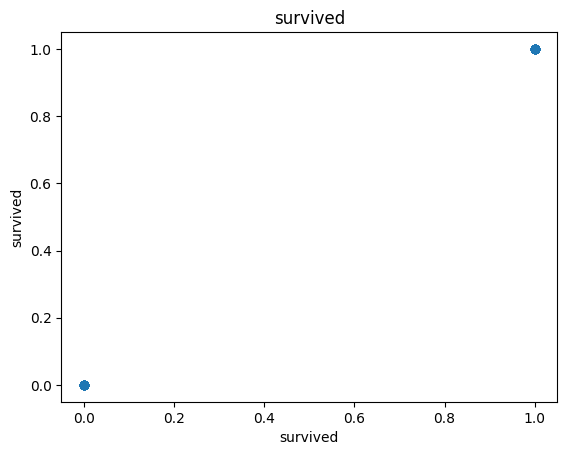

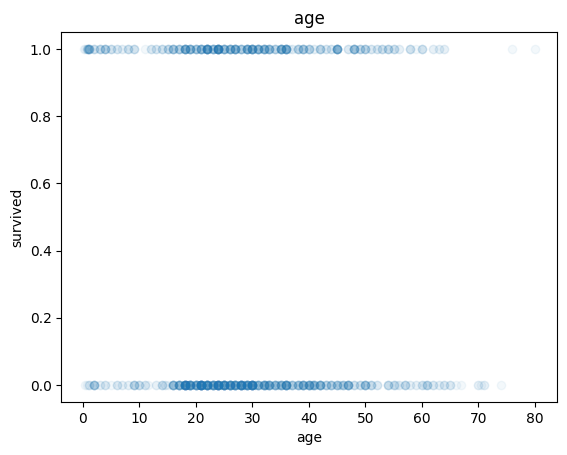

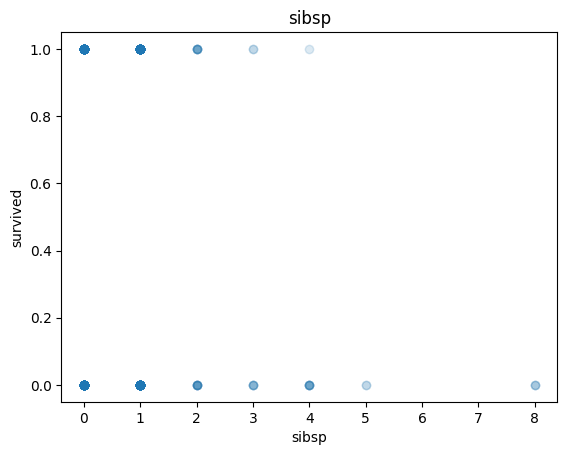

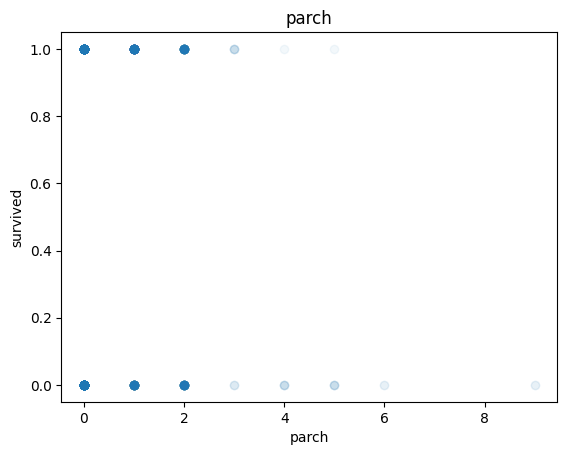

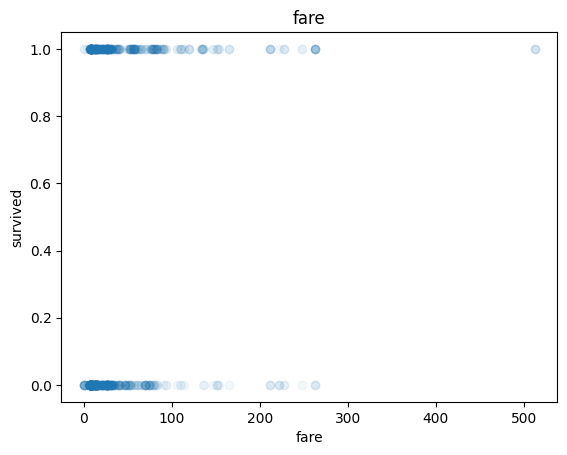

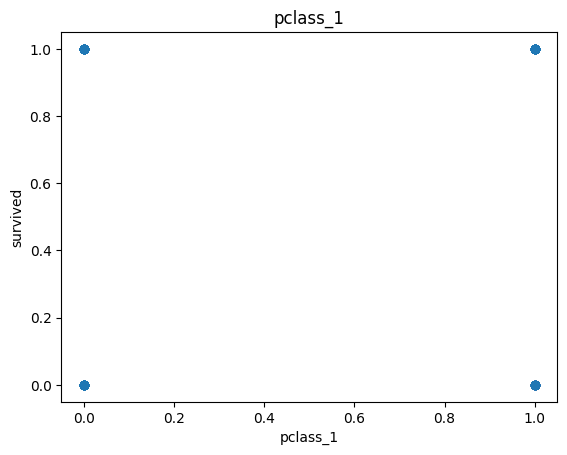

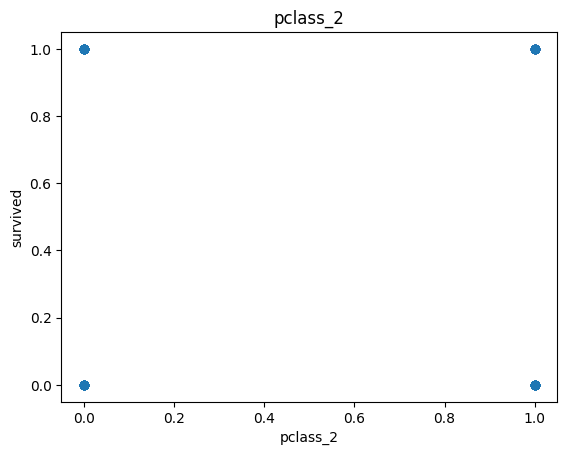

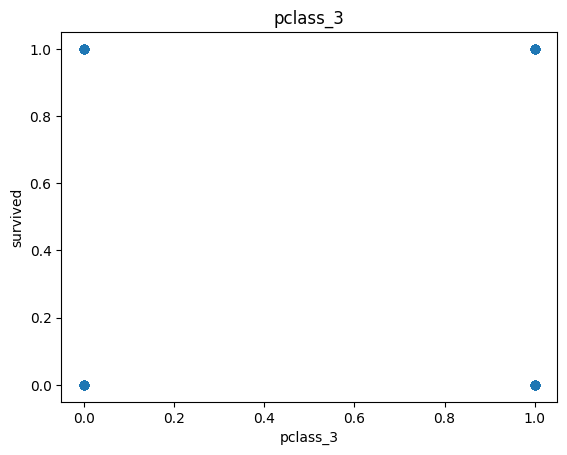

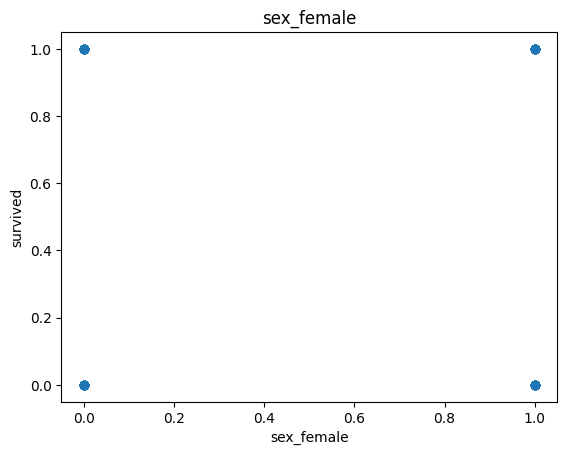

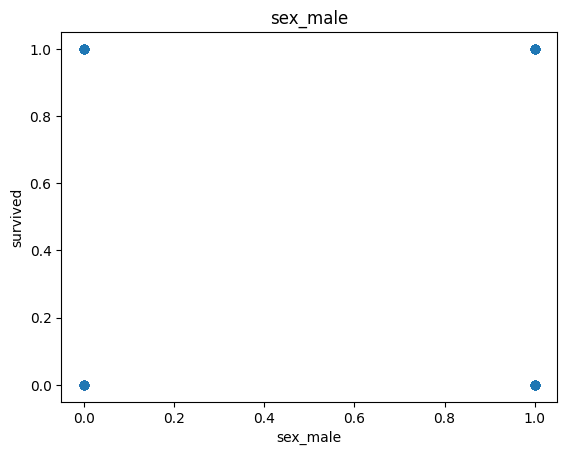

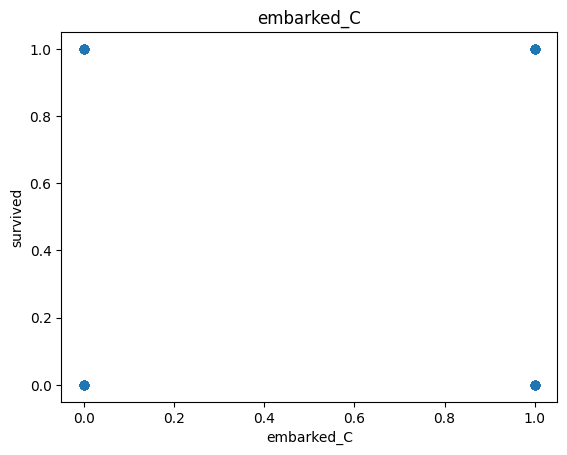

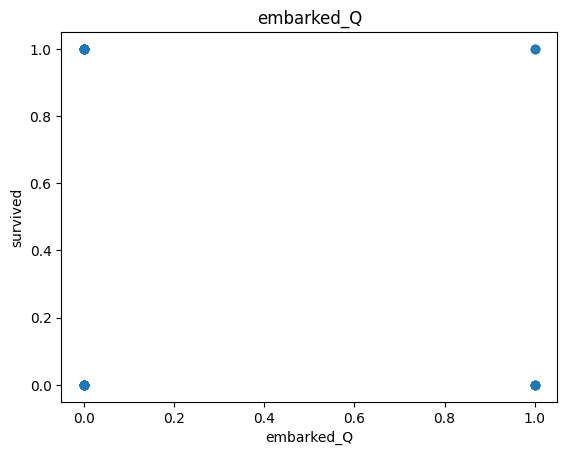

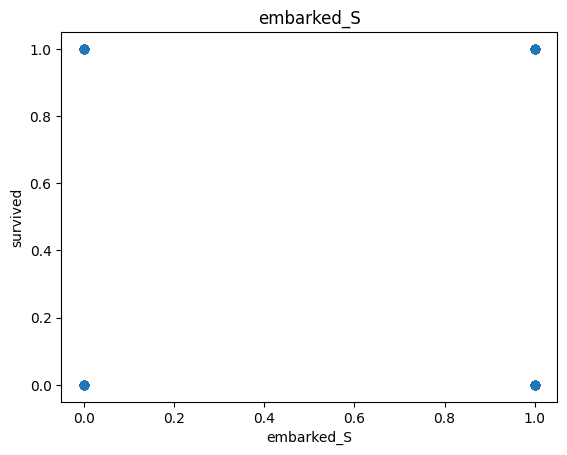

In [14]:
# Lets do some plots to visualize the data
for column in df.columns:
    plt.scatter(df[column],df[y_label], alpha=0.05) # I am using a low alpha value to better be able to tell where the data points are densest.
    plt.title(column)
    plt.ylabel(y_label)
    plt.xlabel(column)
    plt.show()

In [53]:
# Looking at the plots, it is really hard to tell whether there is any kind of relationship between the values, especially the one-hot encoded ones. I guess that is something to keep in mind for the future.

# Lets make some functions to help.

### Normalization
# Scale and normalize the features.
def norm_n_scale(df_in, columns):
    means = df_in[columns].mean()
    stds = df_in[columns].std()
    scaled_df = df_in[columns].copy()
    test_index = 5
    
    for index,column in enumerate(columns):
        scaled_df[column] = df_in[column].values - means.iloc[index]
        scaled_df[column] = scaled_df[column].values / stds.iloc[index]
        
    return scaled_df

### Polynomial
# I want to try multiple degrees of the polynomial parameters. This might only really be usful for age and fare.
def polynomial(dataframe, columns, degree):
    df_poly = pd.DataFrame()
    for column in columns:
        for i in range(2, degree + 1):
            df_poly[f"{column}^{i}"] = dataframe[column] ** i
    new_df = pd.concat([dataframe, df_poly], axis=1)
    return new_df

### Split into train, val, test
def split_dataframe(dataframe):
    df_train,df_temp = train_test_split(dataframe, test_size=0.4, random_state=42)
    df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)
    
    return df_train,df_val, df_test

### Cost function + Regularization
def logistic_regression_cost(X, y, theta, lambda_):
    # Calculate the predictions
    z = np.dot(X, theta)
    f = 1/(1+np.exp(-z))

    # Cost without regularization
    cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)

    # Regularization, excluding theta[0], which is the bias term.
    reg_term = (lambda_ / (2 * len(y))) * np.sum(theta[1:] ** 2)

    # Add regularization to the cost
    reg_cost = cost + reg_term

    return reg_cost


### Gradient Descent
def logistic_regression_gd(X, y, theta, lambda_, alpha_):
    # Calculate the predictions
    z = np.dot(X, theta)
    f = 1/(1+np.exp(-z))

    # Number of training examples
    m = len(y)

    # Calculate the gradients
    error = f-y
    gradient = np.dot(X.T, error) / m

    # Regularizaion term
    reg_term = (lambda_ / m) * theta
    reg_term[0] = 0  # No regularization for the bias term

    # Update theta
    new_theta = theta - alpha_ * (gradient + reg_term)
    
    return new_theta

In [13]:
df[as_is] = norm_n_scale(df, as_is)
ones_col = pd.DataFrame(np.ones(len(df), dtype=int), columns=['Bias'])
df = pd.concat([ones_col, df], axis=1)
df.head()

In [28]:
all_column_names = list(df.columns)

# Split the data into train, validation, and test sets
train, val, test = split_dataframe(df)

# Add column names to the features dataframes
train = pd.DataFrame(train, columns=all_column_names)
val = pd.DataFrame(val, columns=all_column_names)
test = pd.DataFrame(test, columns=all_column_names)

# Create separate dataframes for the y labels
y_train = train[y_label]
y_val = val[y_label]
y_test = test[y_label]

train = train.drop(columns=y_label)
val = val.drop(columns=y_label)
test = test.drop(columns=y_label)

['Bias', 'survived', 'age', 'sibsp', 'parch', 'fare', 'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S']


In [54]:
# Hyperparameters
polynomials = [1,2,3,4,5]
lambda_ = [0,1e-06,1e-04,1e-02]
alpha_ = [1e-07,1e-08,1e-09,1e-10,1e-20,1e-30]

#Iterations
iterations = 5

train_cost_history = {}
val_cost_history = {}
best_theta = []
lowest_cost = 100000000000000000

# Perform grid search to find the best hyperparameters
for p in polynomials:
    if p == 1:
        train_poly = train
        val_poly = val
    if p >= 2:
        train_poly = polynomial(train,as_is,p)
        val_poly = polynomial(val,as_is,p)
    for l in lambda_:
        for a in alpha_:
            theta = (np.ones(train_poly.shape[1])) /10
            for i in range(iterations):
                logistic_regression_gd(train_poly, y_train, theta, l, a)
            print("")
            train_cost_history[f"{p}, {l}, {a}"] = logistic_regression_cost(train_poly, y_train, theta, l)
            print(str(logistic_regression_cost(train_poly, y_train, theta, l)))
            val_cost_history[f"{p}, {l}, {a}"] = logistic_regression_cost(val_poly, y_val, theta, l)
            print(str(logistic_regression_cost(val_poly, y_val, theta, l)))
            if val_cost_history[f"{p}, {l}, {a}"] < lowest_cost:
                best_theta = theta
                print(" best: ")
                lowest_cost = val_cost_history[f"{p}, {l}, {a}"]
            
            print(f"poly: {p}, lambda: {l}, alpha: {a} has been completed.")

# I am getting extremely low cost. Something is wrong.


0.5915803287485815
0.6094900635060098
 best: 
poly: 1, lambda: 0, alpha: 1e-07 has been completed.

0.5915803287485815
0.6094900635060098
poly: 1, lambda: 0, alpha: 1e-08 has been completed.

0.5915803287485815
0.6094900635060098
poly: 1, lambda: 0, alpha: 1e-09 has been completed.

0.5915803287485815
0.6094900635060098
poly: 1, lambda: 0, alpha: 1e-10 has been completed.

0.5915803287485815
0.6094900635060098
poly: 1, lambda: 0, alpha: 1e-20 has been completed.

0.5915803287485815
0.6094900635060098
poly: 1, lambda: 0, alpha: 1e-30 has been completed.

0.5915803288250145
0.6094900637350174
poly: 1, lambda: 1e-06, alpha: 1e-07 has been completed.

0.5915803288250145
0.6094900637350174
poly: 1, lambda: 1e-06, alpha: 1e-08 has been completed.

0.5915803288250145
0.6094900637350174
poly: 1, lambda: 1e-06, alpha: 1e-09 has been completed.

0.5915803288250145
0.6094900637350174
poly: 1, lambda: 1e-06, alpha: 1e-10 has been completed.

0.5915803288250145
0.6094900637350174
poly: 1, lambda: 

C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\2545433810.py:43: RuntimeWarning: divide by zero encountered in log
  cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)
C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\2545433810.py:43: RuntimeWarning: divide by zero encountered in log
  cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)
C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\2545433810.py:43: RuntimeWarning: divide by zero encountered in log
  cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)
C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\2545433810.py:43: RuntimeWarning: divide by zero encountered in log
  cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)
C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\2545433810.py:43: RuntimeWarning: divide by zero encountered in log
  cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)
C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\254543381


inf
inf
poly: 4, lambda: 0.0001, alpha: 1e-07 has been completed.

inf
inf
poly: 4, lambda: 0.0001, alpha: 1e-08 has been completed.

inf
inf
poly: 4, lambda: 0.0001, alpha: 1e-09 has been completed.

inf
inf
poly: 4, lambda: 0.0001, alpha: 1e-10 has been completed.

inf
inf
poly: 4, lambda: 0.0001, alpha: 1e-20 has been completed.

inf
inf
poly: 4, lambda: 0.0001, alpha: 1e-30 has been completed.

inf
inf
poly: 4, lambda: 0.01, alpha: 1e-07 has been completed.

inf
inf
poly: 4, lambda: 0.01, alpha: 1e-08 has been completed.

inf
inf
poly: 4, lambda: 0.01, alpha: 1e-09 has been completed.

inf
inf
poly: 4, lambda: 0.01, alpha: 1e-10 has been completed.

inf
inf
poly: 4, lambda: 0.01, alpha: 1e-20 has been completed.

inf
inf
poly: 4, lambda: 0.01, alpha: 1e-30 has been completed.

inf
inf
poly: 5, lambda: 0, alpha: 1e-07 has been completed.

inf
inf
poly: 5, lambda: 0, alpha: 1e-08 has been completed.

inf
inf
poly: 5, lambda: 0, alpha: 1e-09 has been completed.

inf
inf
poly: 5, lamb

C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\2545433810.py:43: RuntimeWarning: divide by zero encountered in log
  cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)
C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\2545433810.py:43: RuntimeWarning: divide by zero encountered in log
  cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)
C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\2545433810.py:43: RuntimeWarning: divide by zero encountered in log
  cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)
C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\2545433810.py:43: RuntimeWarning: divide by zero encountered in log
  cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)
C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\2545433810.py:43: RuntimeWarning: divide by zero encountered in log
  cost = -(np.sum(y * np.log(f) + (1-y) * np.log(1-f)))/len(y)
C:\Users\CherryBerry\AppData\Local\Temp\ipykernel_14984\254543381